<a href="https://colab.research.google.com/github/hwan615/GAN/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리 import

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
%matplotlib inline

# Tensorflow keras dataset 에서 mninst 데이터 임포트

Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


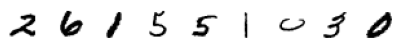

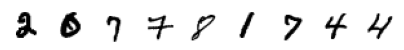

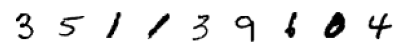

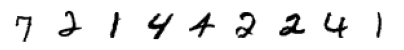

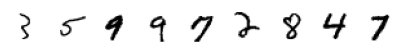

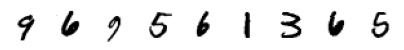

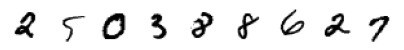

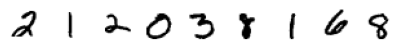

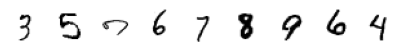

In [ ]:
from tensorflow.keras.datasets import mnist

(trainX, trainY), (testX, testY) = mnist.load_data()

print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testY.shape))

# 가져온 데이터 미리보기
for k in range(9):
    plt.figure(figsize=(7, 7))
    for j in range(1, 10):
        i = np.random.randint(0, 10000)
        plt.subplot(9, 9, j)
        plt.imshow(trainX[i], cmap='gray_r')
        plt.axis('off')
    plt.show()

# Data Normalization

In [ ]:
# [0 ~ 255] 사이의 값을 가지는 픽셀 정보를 255 로 나누어 [0 ~ 1] 사이의 값을 갖도록 정규화

trainX = [image / 255.0 for image in trainX]
testX = [image / 255.0 for image in testX]

trainX = np.reshape(trainX, (60000, 28, 28, 1))
testX = np.reshape(testX, (10000, 28, 28, 1))

print (trainX.shape, testX.shape, trainY.shape, testY.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1) (60000,) (10000,)


# Generator Network

In [ ]:
# 이미지 생성 Network
random_input = tensorflow.keras.layers.Input(shape = 50)

x = tensorflow.keras.layers.Dense(1200, activation='relu')(random_input)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
x = tensorflow.keras.layers.Dense(1000, activation='relu')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
x = tensorflow.keras.layers.Dense(28*28)(x)
x = tensorflow.keras.layers.Reshape((28, 28, 1))(x)

# Sigmoid 함수를 통해서 생성된 이미지 결과를 [0 ~ 1] 사이의 값으로 반환
# 0.5 이하 -> fake, 0.5 이상 -> true 로 판단
generated_image = tensorflow.keras.layers.Activation('sigmoid')(x)

generator_network = tensorflow.keras.models.Model(inputs=random_input, outputs=generated_image)
generator_network.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50)]              0         
                                                                 
 dense_3 (Dense)             (None, 1200)              61200     
                                                                 
 batch_normalization_2 (Batc  (None, 1200)             4800      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 1000)              1201000   
                                                                 
 batch_normalization_3 (Batc  (None, 1000)             4000      
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 784)               7847

# Discriminator Network

In [ ]:
# 이미지 진위 판단 Network

# 실제 이미지를 input 으로 받는다
image_input = tensorflow.keras.layers.Input(shape=(28, 28, 1))

x = tensorflow.keras.layers.Flatten()(image_input)
x = tensorflow.keras.layers.Dense(256, activation='relu')(x)
x = tensorflow.keras.layers.Dropout(0.3)(x)
x = tensorflow.keras.layers.Dense(128, activation='relu')(x)
x = tensorflow.keras.layers.Dropout(0.5)(x)
x = tensorflow.keras.layers.Dense(1)(x)

# Sigmoid 함수를 통해서 생성된 이미지 결과를 [0 ~ 1] 사이의 값으로 반환
# 0.5 이하 -> fake, 0.5 이상 -> true 로 판단
real_vs_fake_output = tensorflow.keras.layers.Activation('sigmoid')(x)

discriminator_network = tensorflow.keras.models.Model(inputs=image_input, outputs=real_vs_fake_output)
discriminator_network.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               200960    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 129 

In [ ]:
# Adam Optimizer 실행
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.5)
discriminator_network.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

# Define GAN model


In [ ]:
# Discriminator Network 가 학습되지 않도록 함
discriminator_network.trainable=False

g_output = generator_network(random_input)
d_output = discriminator_network(g_output)

gan_model = tensorflow.keras.models.Model(random_input, d_output)
gan_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50)]              0         
                                                                 
 model_1 (Functional)        (None, 28, 28, 1)         2055784   
                                                                 
 model_2 (Functional)        (None, 1)                 233985    
                                                                 
Total params: 2,289,769
Trainable params: 2,051,384
Non-trainable params: 238,385
_________________________________________________________________


# Compiling GAN

In [ ]:
# binary_crossentropy Loss Function 과 Adam Optimizer 사용
gan_model.compile(loss='binary_crossentropy', optimizer=adam_optimizer)

# Define Data Generators

In [ ]:
indices = [i for i in range(len(trainX))]

def get_random_noise(batch_size, noise_size):
    random_values = np.random.randn(batch_size*noise_size)
    random_noise_batch = np.reshape(random_values, (batch_size, noise_size))
    return random_noise_batch

# 가짜 이미지 샘플
def get_fake_samples(generator_network, batch_size, noise_size):
    random_noise_batch = get_random_noise(batch_size, noise_size) 
    fake_samples = generator_network.predict_on_batch(random_noise_batch)
    return fake_samples

# 진짜 이미지 샘플
def get_real_samples(batch_size):
    random_indices = np.random.choice(indices, size=batch_size)
    real_images = trainX[np.array(random_indices),:]
    return real_images

# 결과 display
def show_generator_results(generator_network):
    for k in range(9):
        plt.figure(figsize=(7, 7))
        fake_samples = get_fake_samples(generator_network, 9, noise_size)
        for j in range(9):
            plt.subplot(990 + 1 + j)
            plt.imshow(fake_samples[j,:,:,-1], cmap='gray_r')
            plt.axis('off')
            #plt.title(trainY[i])
        plt.show()
    return

# Training GAN

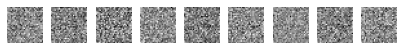

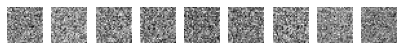

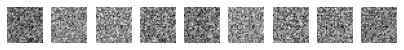

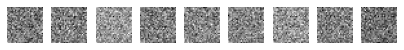

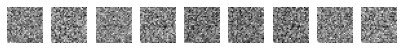

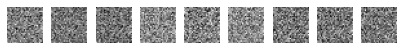

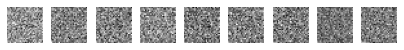

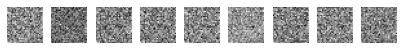

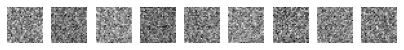

Epoch:0, Step:0, D-Loss:0.709, D-Acc:50.000, G-Loss:0.982
Epoch:0, Step:50, D-Loss:0.186, D-Acc:99.000, G-Loss:3.271
Epoch:0, Step:100, D-Loss:0.054, D-Acc:100.000, G-Loss:5.026
Epoch:0, Step:150, D-Loss:0.027, D-Acc:100.000, G-Loss:6.473
Epoch:0, Step:200, D-Loss:0.023, D-Acc:100.000, G-Loss:8.985
Epoch:0, Step:250, D-Loss:0.039, D-Acc:99.000, G-Loss:11.714
Epoch:0, Step:300, D-Loss:0.081, D-Acc:98.000, G-Loss:13.959
Epoch:0, Step:350, D-Loss:0.287, D-Acc:90.000, G-Loss:13.725
Epoch:0, Step:400, D-Loss:0.191, D-Acc:95.000, G-Loss:12.929
Epoch:0, Step:450, D-Loss:0.175, D-Acc:96.000, G-Loss:11.917
Epoch:1, Step:0, D-Loss:0.141, D-Acc:97.000, G-Loss:12.527
Epoch:1, Step:50, D-Loss:0.167, D-Acc:95.000, G-Loss:13.167
Epoch:1, Step:100, D-Loss:0.172, D-Acc:93.000, G-Loss:11.806
Epoch:1, Step:150, D-Loss:0.158, D-Acc:96.000, G-Loss:14.073
Epoch:1, Step:200, D-Loss:0.136, D-Acc:95.000, G-Loss:12.073
Epoch:1, Step:250, D-Loss:0.188, D-Acc:93.000, G-Loss:14.031
Epoch:1, Step:300, D-Loss:0.214,

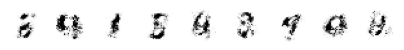

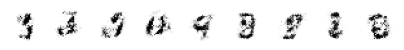

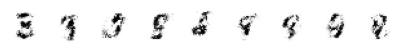

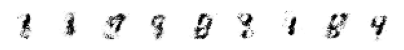

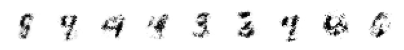

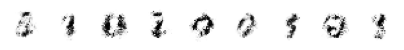

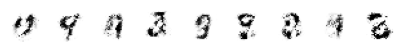

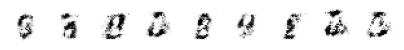

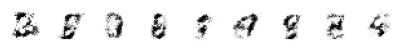

Epoch:10, Step:0, D-Loss:0.330, D-Acc:84.000, G-Loss:1.707
Epoch:10, Step:50, D-Loss:0.432, D-Acc:84.000, G-Loss:1.709
Epoch:10, Step:100, D-Loss:0.307, D-Acc:87.000, G-Loss:1.712
Epoch:10, Step:150, D-Loss:0.444, D-Acc:79.000, G-Loss:1.582
Epoch:10, Step:200, D-Loss:0.397, D-Acc:81.000, G-Loss:1.589
Epoch:10, Step:250, D-Loss:0.326, D-Acc:83.000, G-Loss:1.662
Epoch:10, Step:300, D-Loss:0.365, D-Acc:85.000, G-Loss:1.634
Epoch:10, Step:350, D-Loss:0.414, D-Acc:83.000, G-Loss:1.524
Epoch:10, Step:400, D-Loss:0.437, D-Acc:80.000, G-Loss:1.504
Epoch:10, Step:450, D-Loss:0.387, D-Acc:82.000, G-Loss:1.457
Epoch:11, Step:0, D-Loss:0.370, D-Acc:85.000, G-Loss:1.484
Epoch:11, Step:50, D-Loss:0.467, D-Acc:82.000, G-Loss:1.699
Epoch:11, Step:100, D-Loss:0.358, D-Acc:85.000, G-Loss:1.471
Epoch:11, Step:150, D-Loss:0.393, D-Acc:85.000, G-Loss:1.486
Epoch:11, Step:200, D-Loss:0.436, D-Acc:78.000, G-Loss:1.602
Epoch:11, Step:250, D-Loss:0.327, D-Acc:88.000, G-Loss:1.546
Epoch:11, Step:300, D-Loss:0.4

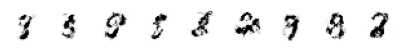

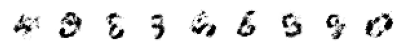

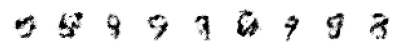

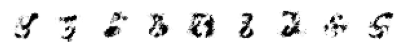

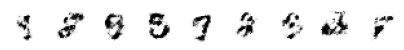

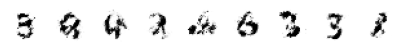

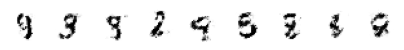

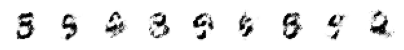

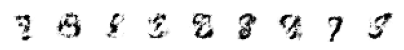

Epoch:20, Step:0, D-Loss:0.437, D-Acc:81.000, G-Loss:1.524
Epoch:20, Step:50, D-Loss:0.501, D-Acc:74.000, G-Loss:1.442
Epoch:20, Step:100, D-Loss:0.404, D-Acc:81.000, G-Loss:1.607
Epoch:20, Step:150, D-Loss:0.373, D-Acc:88.000, G-Loss:1.428
Epoch:20, Step:200, D-Loss:0.465, D-Acc:78.000, G-Loss:1.507
Epoch:20, Step:250, D-Loss:0.625, D-Acc:71.000, G-Loss:1.446
Epoch:20, Step:300, D-Loss:0.537, D-Acc:68.000, G-Loss:1.278
Epoch:20, Step:350, D-Loss:0.372, D-Acc:86.000, G-Loss:1.341
Epoch:20, Step:400, D-Loss:0.437, D-Acc:80.000, G-Loss:1.228
Epoch:20, Step:450, D-Loss:0.467, D-Acc:77.000, G-Loss:1.481
Epoch:21, Step:0, D-Loss:0.550, D-Acc:72.000, G-Loss:1.372
Epoch:21, Step:50, D-Loss:0.422, D-Acc:77.000, G-Loss:1.483
Epoch:21, Step:100, D-Loss:0.472, D-Acc:78.000, G-Loss:1.520
Epoch:21, Step:150, D-Loss:0.449, D-Acc:77.000, G-Loss:1.329
Epoch:21, Step:200, D-Loss:0.528, D-Acc:76.000, G-Loss:1.295
Epoch:21, Step:250, D-Loss:0.453, D-Acc:78.000, G-Loss:1.533
Epoch:21, Step:300, D-Loss:0.4

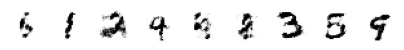

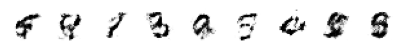

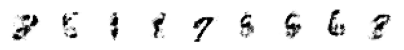

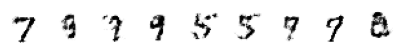

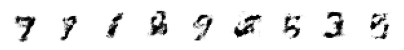

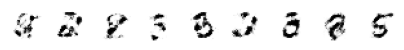

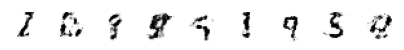

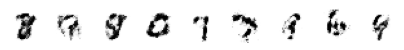

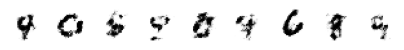

Epoch:30, Step:0, D-Loss:0.541, D-Acc:74.000, G-Loss:1.250
Epoch:30, Step:50, D-Loss:0.475, D-Acc:78.000, G-Loss:1.175
Epoch:30, Step:100, D-Loss:0.551, D-Acc:70.000, G-Loss:1.276
Epoch:30, Step:150, D-Loss:0.566, D-Acc:69.000, G-Loss:1.256
Epoch:30, Step:200, D-Loss:0.579, D-Acc:71.000, G-Loss:1.176
Epoch:30, Step:250, D-Loss:0.563, D-Acc:69.000, G-Loss:1.215
Epoch:30, Step:300, D-Loss:0.592, D-Acc:66.000, G-Loss:1.130
Epoch:30, Step:350, D-Loss:0.561, D-Acc:72.000, G-Loss:1.179
Epoch:30, Step:400, D-Loss:0.510, D-Acc:75.000, G-Loss:1.243
Epoch:30, Step:450, D-Loss:0.572, D-Acc:69.000, G-Loss:1.165
Epoch:31, Step:0, D-Loss:0.472, D-Acc:77.000, G-Loss:1.218
Epoch:31, Step:50, D-Loss:0.497, D-Acc:76.000, G-Loss:1.115
Epoch:31, Step:100, D-Loss:0.523, D-Acc:73.000, G-Loss:1.107
Epoch:31, Step:150, D-Loss:0.546, D-Acc:73.000, G-Loss:1.146
Epoch:31, Step:200, D-Loss:0.500, D-Acc:79.000, G-Loss:1.303
Epoch:31, Step:250, D-Loss:0.628, D-Acc:72.000, G-Loss:1.194
Epoch:31, Step:300, D-Loss:0.5

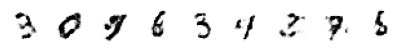

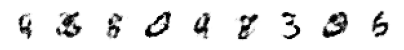

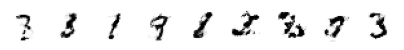

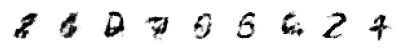

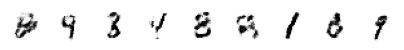

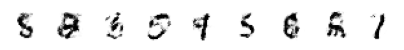

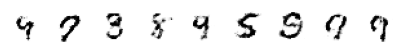

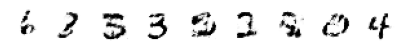

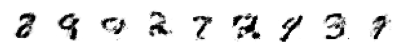

Epoch:40, Step:0, D-Loss:0.536, D-Acc:76.000, G-Loss:1.056
Epoch:40, Step:50, D-Loss:0.671, D-Acc:63.000, G-Loss:1.020
Epoch:40, Step:100, D-Loss:0.595, D-Acc:66.000, G-Loss:0.986
Epoch:40, Step:150, D-Loss:0.610, D-Acc:64.000, G-Loss:1.097
Epoch:40, Step:200, D-Loss:0.598, D-Acc:68.000, G-Loss:1.004
Epoch:40, Step:250, D-Loss:0.573, D-Acc:67.000, G-Loss:1.034
Epoch:40, Step:300, D-Loss:0.542, D-Acc:76.000, G-Loss:0.985
Epoch:40, Step:350, D-Loss:0.610, D-Acc:65.000, G-Loss:0.997
Epoch:40, Step:400, D-Loss:0.531, D-Acc:71.000, G-Loss:0.986
Epoch:40, Step:450, D-Loss:0.605, D-Acc:68.000, G-Loss:1.026
Epoch:41, Step:0, D-Loss:0.700, D-Acc:57.000, G-Loss:1.005
Epoch:41, Step:50, D-Loss:0.583, D-Acc:69.000, G-Loss:0.922
Epoch:41, Step:100, D-Loss:0.629, D-Acc:63.000, G-Loss:1.023
Epoch:41, Step:150, D-Loss:0.528, D-Acc:76.000, G-Loss:1.067
Epoch:41, Step:200, D-Loss:0.553, D-Acc:66.000, G-Loss:1.020
Epoch:41, Step:250, D-Loss:0.545, D-Acc:74.000, G-Loss:1.023
Epoch:41, Step:300, D-Loss:0.5

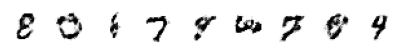

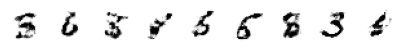

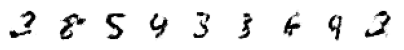

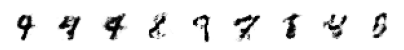

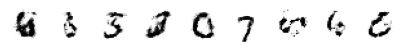

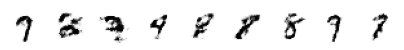

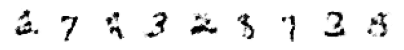

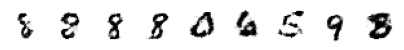

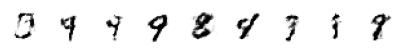

Epoch:50, Step:0, D-Loss:0.659, D-Acc:62.000, G-Loss:0.942
Epoch:50, Step:50, D-Loss:0.650, D-Acc:56.000, G-Loss:0.884
Epoch:50, Step:100, D-Loss:0.628, D-Acc:58.000, G-Loss:0.895
Epoch:50, Step:150, D-Loss:0.671, D-Acc:57.000, G-Loss:0.897
Epoch:50, Step:200, D-Loss:0.597, D-Acc:69.000, G-Loss:0.869
Epoch:50, Step:250, D-Loss:0.627, D-Acc:61.000, G-Loss:0.948
Epoch:50, Step:300, D-Loss:0.641, D-Acc:60.000, G-Loss:0.946
Epoch:50, Step:350, D-Loss:0.671, D-Acc:57.000, G-Loss:0.863
Epoch:50, Step:400, D-Loss:0.668, D-Acc:62.000, G-Loss:0.910
Epoch:50, Step:450, D-Loss:0.619, D-Acc:68.000, G-Loss:0.880
Epoch:51, Step:0, D-Loss:0.609, D-Acc:66.000, G-Loss:0.936
Epoch:51, Step:50, D-Loss:0.596, D-Acc:65.000, G-Loss:0.874
Epoch:51, Step:100, D-Loss:0.616, D-Acc:66.000, G-Loss:0.880
Epoch:51, Step:150, D-Loss:0.580, D-Acc:72.000, G-Loss:0.928
Epoch:51, Step:200, D-Loss:0.625, D-Acc:64.000, G-Loss:0.896
Epoch:51, Step:250, D-Loss:0.653, D-Acc:60.000, G-Loss:0.887
Epoch:51, Step:300, D-Loss:0.6

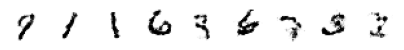

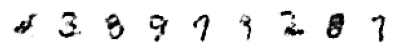

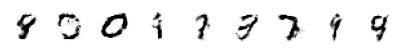

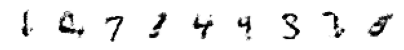

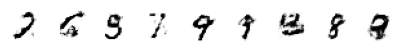

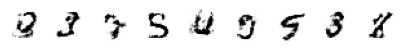

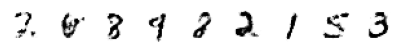

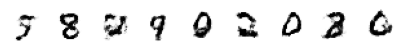

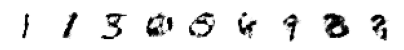

Epoch:60, Step:0, D-Loss:0.629, D-Acc:67.000, G-Loss:0.856
Epoch:60, Step:50, D-Loss:0.674, D-Acc:62.000, G-Loss:0.874
Epoch:60, Step:100, D-Loss:0.599, D-Acc:71.000, G-Loss:0.900
Epoch:60, Step:150, D-Loss:0.664, D-Acc:58.000, G-Loss:0.853
Epoch:60, Step:200, D-Loss:0.568, D-Acc:75.000, G-Loss:0.876
Epoch:60, Step:250, D-Loss:0.701, D-Acc:51.000, G-Loss:0.824
Epoch:60, Step:300, D-Loss:0.609, D-Acc:70.000, G-Loss:0.871
Epoch:60, Step:350, D-Loss:0.667, D-Acc:56.000, G-Loss:0.916
Epoch:60, Step:400, D-Loss:0.606, D-Acc:63.000, G-Loss:0.928
Epoch:60, Step:450, D-Loss:0.651, D-Acc:62.000, G-Loss:0.830
Epoch:61, Step:0, D-Loss:0.654, D-Acc:64.000, G-Loss:0.877
Epoch:61, Step:50, D-Loss:0.693, D-Acc:53.000, G-Loss:0.871
Epoch:61, Step:100, D-Loss:0.648, D-Acc:62.000, G-Loss:0.869
Epoch:61, Step:150, D-Loss:0.635, D-Acc:60.000, G-Loss:0.851
Epoch:61, Step:200, D-Loss:0.606, D-Acc:65.000, G-Loss:0.827
Epoch:61, Step:250, D-Loss:0.617, D-Acc:72.000, G-Loss:0.846
Epoch:61, Step:300, D-Loss:0.6

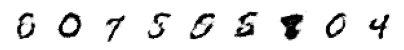

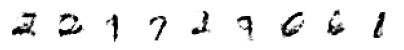

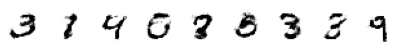

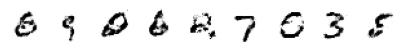

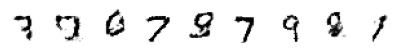

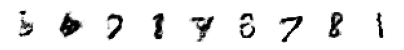

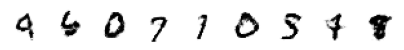

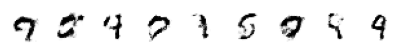

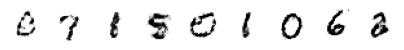

Epoch:70, Step:0, D-Loss:0.664, D-Acc:58.000, G-Loss:0.827
Epoch:70, Step:50, D-Loss:0.606, D-Acc:67.000, G-Loss:0.785
Epoch:70, Step:100, D-Loss:0.608, D-Acc:64.000, G-Loss:0.831
Epoch:70, Step:150, D-Loss:0.652, D-Acc:61.000, G-Loss:0.878
Epoch:70, Step:200, D-Loss:0.639, D-Acc:64.000, G-Loss:0.886
Epoch:70, Step:250, D-Loss:0.652, D-Acc:60.000, G-Loss:0.863
Epoch:70, Step:300, D-Loss:0.637, D-Acc:67.000, G-Loss:0.866
Epoch:70, Step:350, D-Loss:0.629, D-Acc:67.000, G-Loss:0.855
Epoch:70, Step:400, D-Loss:0.637, D-Acc:63.000, G-Loss:0.873
Epoch:70, Step:450, D-Loss:0.682, D-Acc:59.000, G-Loss:0.902
Epoch:71, Step:0, D-Loss:0.664, D-Acc:56.000, G-Loss:0.844
Epoch:71, Step:50, D-Loss:0.694, D-Acc:53.000, G-Loss:0.813
Epoch:71, Step:100, D-Loss:0.665, D-Acc:61.000, G-Loss:0.827
Epoch:71, Step:150, D-Loss:0.660, D-Acc:63.000, G-Loss:0.820
Epoch:71, Step:200, D-Loss:0.618, D-Acc:70.000, G-Loss:0.864
Epoch:71, Step:250, D-Loss:0.622, D-Acc:63.000, G-Loss:0.771
Epoch:71, Step:300, D-Loss:0.5

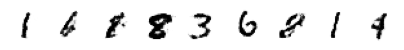

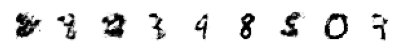

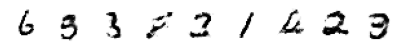

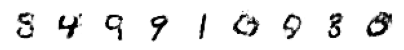

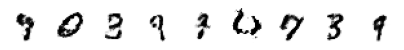

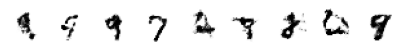

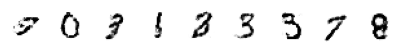

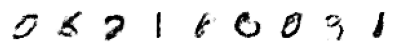

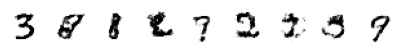

Epoch:80, Step:0, D-Loss:0.641, D-Acc:66.000, G-Loss:0.802
Epoch:80, Step:50, D-Loss:0.619, D-Acc:69.000, G-Loss:0.789
Epoch:80, Step:100, D-Loss:0.635, D-Acc:61.000, G-Loss:0.812
Epoch:80, Step:150, D-Loss:0.626, D-Acc:70.000, G-Loss:0.841
Epoch:80, Step:200, D-Loss:0.605, D-Acc:60.000, G-Loss:0.827
Epoch:80, Step:250, D-Loss:0.601, D-Acc:71.000, G-Loss:0.806
Epoch:80, Step:300, D-Loss:0.688, D-Acc:60.000, G-Loss:0.825
Epoch:80, Step:350, D-Loss:0.683, D-Acc:63.000, G-Loss:0.788
Epoch:80, Step:400, D-Loss:0.636, D-Acc:64.000, G-Loss:0.862
Epoch:80, Step:450, D-Loss:0.627, D-Acc:62.000, G-Loss:0.830
Epoch:81, Step:0, D-Loss:0.692, D-Acc:57.000, G-Loss:0.843
Epoch:81, Step:50, D-Loss:0.672, D-Acc:54.000, G-Loss:0.800
Epoch:81, Step:100, D-Loss:0.676, D-Acc:56.000, G-Loss:0.818
Epoch:81, Step:150, D-Loss:0.647, D-Acc:63.000, G-Loss:0.793
Epoch:81, Step:200, D-Loss:0.633, D-Acc:63.000, G-Loss:0.805
Epoch:81, Step:250, D-Loss:0.638, D-Acc:62.000, G-Loss:0.800
Epoch:81, Step:300, D-Loss:0.6

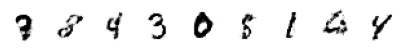

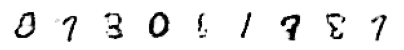

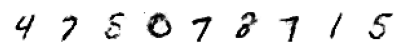

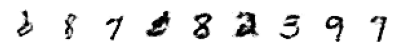

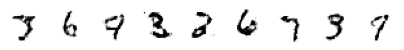

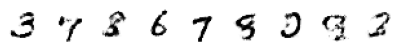

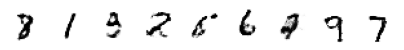

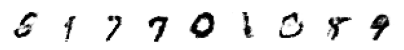

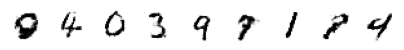

Epoch:90, Step:0, D-Loss:0.643, D-Acc:59.000, G-Loss:0.824
Epoch:90, Step:50, D-Loss:0.619, D-Acc:68.000, G-Loss:0.861
Epoch:90, Step:100, D-Loss:0.647, D-Acc:67.000, G-Loss:0.828
Epoch:90, Step:150, D-Loss:0.671, D-Acc:63.000, G-Loss:0.872
Epoch:90, Step:200, D-Loss:0.659, D-Acc:62.000, G-Loss:0.811
Epoch:90, Step:250, D-Loss:0.654, D-Acc:64.000, G-Loss:0.843
Epoch:90, Step:300, D-Loss:0.635, D-Acc:67.000, G-Loss:0.813
Epoch:90, Step:350, D-Loss:0.613, D-Acc:68.000, G-Loss:0.831
Epoch:90, Step:400, D-Loss:0.607, D-Acc:68.000, G-Loss:0.818
Epoch:90, Step:450, D-Loss:0.641, D-Acc:61.000, G-Loss:0.825
Epoch:91, Step:0, D-Loss:0.654, D-Acc:59.000, G-Loss:0.848
Epoch:91, Step:50, D-Loss:0.632, D-Acc:66.000, G-Loss:0.803
Epoch:91, Step:100, D-Loss:0.644, D-Acc:59.000, G-Loss:0.854
Epoch:91, Step:150, D-Loss:0.659, D-Acc:57.000, G-Loss:0.849
Epoch:91, Step:200, D-Loss:0.623, D-Acc:61.000, G-Loss:0.856
Epoch:91, Step:250, D-Loss:0.664, D-Acc:55.000, G-Loss:0.868
Epoch:91, Step:300, D-Loss:0.6

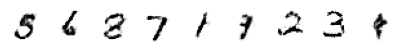

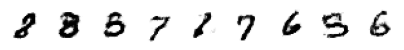

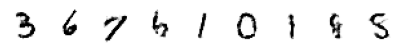

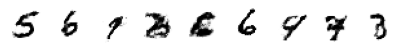

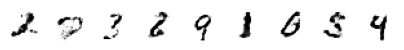

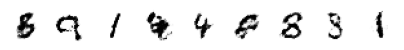

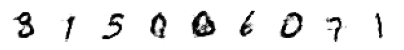

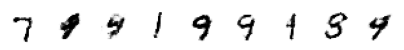

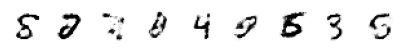

Epoch:100, Step:0, D-Loss:0.639, D-Acc:59.000, G-Loss:0.853
Epoch:100, Step:50, D-Loss:0.667, D-Acc:63.000, G-Loss:0.836
Epoch:100, Step:100, D-Loss:0.624, D-Acc:59.000, G-Loss:0.868
Epoch:100, Step:150, D-Loss:0.666, D-Acc:64.000, G-Loss:0.850
Epoch:100, Step:200, D-Loss:0.627, D-Acc:65.000, G-Loss:0.801
Epoch:100, Step:250, D-Loss:0.617, D-Acc:67.000, G-Loss:0.870
Epoch:100, Step:300, D-Loss:0.603, D-Acc:70.000, G-Loss:0.832
Epoch:100, Step:350, D-Loss:0.656, D-Acc:61.000, G-Loss:0.880
Epoch:100, Step:400, D-Loss:0.632, D-Acc:62.000, G-Loss:0.842
Epoch:100, Step:450, D-Loss:0.663, D-Acc:62.000, G-Loss:0.852
Epoch:101, Step:0, D-Loss:0.647, D-Acc:60.000, G-Loss:0.814
Epoch:101, Step:50, D-Loss:0.615, D-Acc:61.000, G-Loss:0.819
Epoch:101, Step:100, D-Loss:0.621, D-Acc:64.000, G-Loss:0.835
Epoch:101, Step:150, D-Loss:0.646, D-Acc:58.000, G-Loss:0.821
Epoch:101, Step:200, D-Loss:0.612, D-Acc:62.000, G-Loss:0.875
Epoch:101, Step:250, D-Loss:0.658, D-Acc:61.000, G-Loss:0.843
Epoch:101, Ste

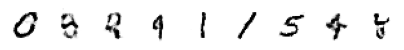

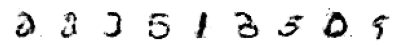

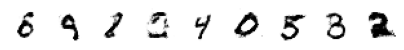

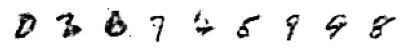

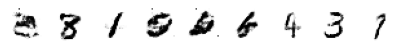

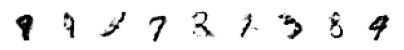

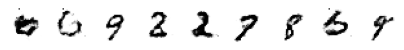

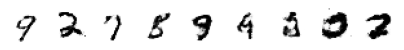

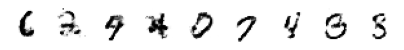

Epoch:110, Step:0, D-Loss:0.694, D-Acc:56.000, G-Loss:0.900
Epoch:110, Step:50, D-Loss:0.705, D-Acc:56.000, G-Loss:0.858
Epoch:110, Step:100, D-Loss:0.608, D-Acc:63.000, G-Loss:0.824
Epoch:110, Step:150, D-Loss:0.659, D-Acc:56.000, G-Loss:0.835
Epoch:110, Step:200, D-Loss:0.664, D-Acc:57.000, G-Loss:0.842
Epoch:110, Step:250, D-Loss:0.671, D-Acc:58.000, G-Loss:0.840
Epoch:110, Step:300, D-Loss:0.675, D-Acc:58.000, G-Loss:0.821
Epoch:110, Step:350, D-Loss:0.687, D-Acc:57.000, G-Loss:0.872
Epoch:110, Step:400, D-Loss:0.618, D-Acc:66.000, G-Loss:0.798
Epoch:110, Step:450, D-Loss:0.650, D-Acc:63.000, G-Loss:0.812
Epoch:111, Step:0, D-Loss:0.622, D-Acc:66.000, G-Loss:0.829
Epoch:111, Step:50, D-Loss:0.649, D-Acc:64.000, G-Loss:0.881
Epoch:111, Step:100, D-Loss:0.638, D-Acc:65.000, G-Loss:0.813
Epoch:111, Step:150, D-Loss:0.651, D-Acc:59.000, G-Loss:0.777
Epoch:111, Step:200, D-Loss:0.659, D-Acc:52.000, G-Loss:0.874
Epoch:111, Step:250, D-Loss:0.626, D-Acc:68.000, G-Loss:0.835
Epoch:111, Ste

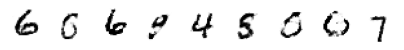

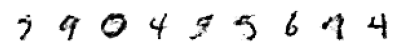

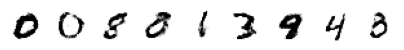

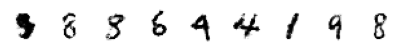

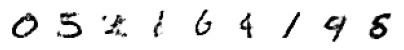

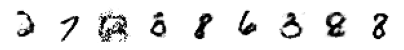

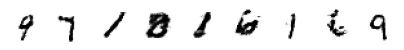

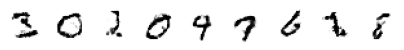

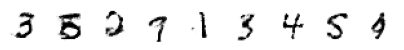

Epoch:120, Step:0, D-Loss:0.600, D-Acc:70.000, G-Loss:0.881
Epoch:120, Step:50, D-Loss:0.576, D-Acc:69.000, G-Loss:0.873
Epoch:120, Step:100, D-Loss:0.659, D-Acc:55.000, G-Loss:0.851
Epoch:120, Step:150, D-Loss:0.618, D-Acc:63.000, G-Loss:0.785
Epoch:120, Step:200, D-Loss:0.675, D-Acc:67.000, G-Loss:0.865
Epoch:120, Step:250, D-Loss:0.643, D-Acc:60.000, G-Loss:0.814
Epoch:120, Step:300, D-Loss:0.611, D-Acc:66.000, G-Loss:0.869
Epoch:120, Step:350, D-Loss:0.614, D-Acc:68.000, G-Loss:0.850
Epoch:120, Step:400, D-Loss:0.637, D-Acc:60.000, G-Loss:0.874
Epoch:120, Step:450, D-Loss:0.637, D-Acc:59.000, G-Loss:0.885
Epoch:121, Step:0, D-Loss:0.611, D-Acc:68.000, G-Loss:0.827
Epoch:121, Step:50, D-Loss:0.607, D-Acc:67.000, G-Loss:0.854
Epoch:121, Step:100, D-Loss:0.616, D-Acc:60.000, G-Loss:0.864
Epoch:121, Step:150, D-Loss:0.653, D-Acc:64.000, G-Loss:0.811
Epoch:121, Step:200, D-Loss:0.657, D-Acc:58.000, G-Loss:0.846
Epoch:121, Step:250, D-Loss:0.612, D-Acc:63.000, G-Loss:0.836
Epoch:121, Ste

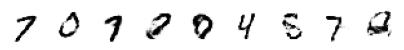

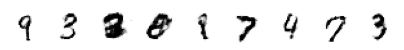

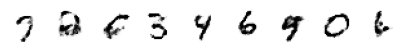

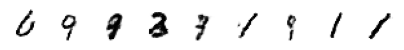

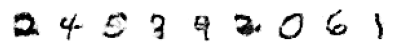

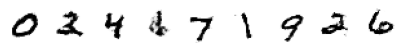

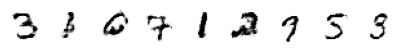

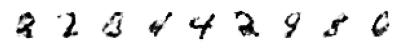

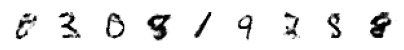

Epoch:130, Step:0, D-Loss:0.607, D-Acc:67.000, G-Loss:0.836
Epoch:130, Step:50, D-Loss:0.679, D-Acc:57.000, G-Loss:0.874
Epoch:130, Step:100, D-Loss:0.638, D-Acc:58.000, G-Loss:0.893
Epoch:130, Step:150, D-Loss:0.651, D-Acc:61.000, G-Loss:0.858
Epoch:130, Step:200, D-Loss:0.675, D-Acc:59.000, G-Loss:0.913
Epoch:130, Step:250, D-Loss:0.634, D-Acc:70.000, G-Loss:0.847
Epoch:130, Step:300, D-Loss:0.603, D-Acc:67.000, G-Loss:0.817
Epoch:130, Step:350, D-Loss:0.625, D-Acc:62.000, G-Loss:0.849
Epoch:130, Step:400, D-Loss:0.632, D-Acc:61.000, G-Loss:0.883
Epoch:130, Step:450, D-Loss:0.600, D-Acc:72.000, G-Loss:0.900
Epoch:131, Step:0, D-Loss:0.587, D-Acc:69.000, G-Loss:0.903
Epoch:131, Step:50, D-Loss:0.615, D-Acc:71.000, G-Loss:0.884
Epoch:131, Step:100, D-Loss:0.629, D-Acc:58.000, G-Loss:0.799
Epoch:131, Step:150, D-Loss:0.656, D-Acc:56.000, G-Loss:0.875
Epoch:131, Step:200, D-Loss:0.618, D-Acc:67.000, G-Loss:0.904
Epoch:131, Step:250, D-Loss:0.612, D-Acc:65.000, G-Loss:0.837
Epoch:131, Ste

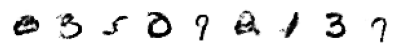

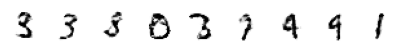

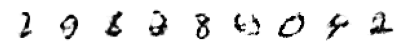

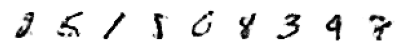

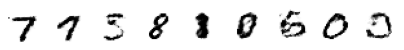

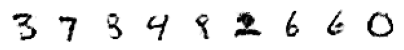

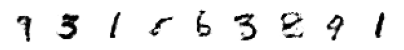

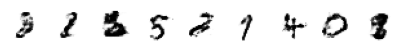

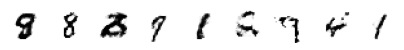

Epoch:140, Step:0, D-Loss:0.655, D-Acc:59.000, G-Loss:0.857
Epoch:140, Step:50, D-Loss:0.655, D-Acc:60.000, G-Loss:0.877
Epoch:140, Step:100, D-Loss:0.628, D-Acc:63.000, G-Loss:0.826
Epoch:140, Step:150, D-Loss:0.638, D-Acc:60.000, G-Loss:0.878
Epoch:140, Step:200, D-Loss:0.640, D-Acc:59.000, G-Loss:0.833
Epoch:140, Step:250, D-Loss:0.711, D-Acc:53.000, G-Loss:0.900
Epoch:140, Step:300, D-Loss:0.642, D-Acc:67.000, G-Loss:0.832
Epoch:140, Step:350, D-Loss:0.621, D-Acc:66.000, G-Loss:0.922
Epoch:140, Step:400, D-Loss:0.651, D-Acc:61.000, G-Loss:0.863
Epoch:140, Step:450, D-Loss:0.607, D-Acc:64.000, G-Loss:0.903
Epoch:141, Step:0, D-Loss:0.594, D-Acc:68.000, G-Loss:0.861
Epoch:141, Step:50, D-Loss:0.574, D-Acc:66.000, G-Loss:0.855
Epoch:141, Step:100, D-Loss:0.639, D-Acc:60.000, G-Loss:0.877
Epoch:141, Step:150, D-Loss:0.691, D-Acc:57.000, G-Loss:0.842
Epoch:141, Step:200, D-Loss:0.658, D-Acc:68.000, G-Loss:0.922
Epoch:141, Step:250, D-Loss:0.668, D-Acc:59.000, G-Loss:0.897
Epoch:141, Ste

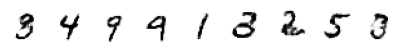

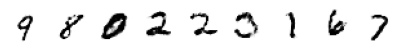

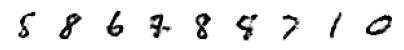

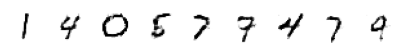

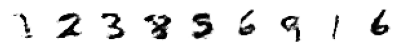

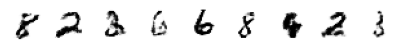

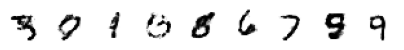

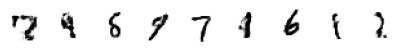

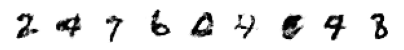

Epoch:150, Step:0, D-Loss:0.546, D-Acc:74.000, G-Loss:0.898
Epoch:150, Step:50, D-Loss:0.685, D-Acc:59.000, G-Loss:0.805
Epoch:150, Step:100, D-Loss:0.622, D-Acc:63.000, G-Loss:0.900
Epoch:150, Step:150, D-Loss:0.694, D-Acc:57.000, G-Loss:0.914
Epoch:150, Step:200, D-Loss:0.636, D-Acc:61.000, G-Loss:0.904
Epoch:150, Step:250, D-Loss:0.630, D-Acc:68.000, G-Loss:0.875
Epoch:150, Step:300, D-Loss:0.658, D-Acc:56.000, G-Loss:0.871
Epoch:150, Step:350, D-Loss:0.623, D-Acc:65.000, G-Loss:0.887
Epoch:150, Step:400, D-Loss:0.659, D-Acc:65.000, G-Loss:0.906
Epoch:150, Step:450, D-Loss:0.564, D-Acc:71.000, G-Loss:0.941
Epoch:151, Step:0, D-Loss:0.610, D-Acc:72.000, G-Loss:0.911
Epoch:151, Step:50, D-Loss:0.599, D-Acc:68.000, G-Loss:0.884
Epoch:151, Step:100, D-Loss:0.627, D-Acc:64.000, G-Loss:0.867
Epoch:151, Step:150, D-Loss:0.634, D-Acc:66.000, G-Loss:0.922
Epoch:151, Step:200, D-Loss:0.646, D-Acc:62.000, G-Loss:0.911
Epoch:151, Step:250, D-Loss:0.660, D-Acc:59.000, G-Loss:0.804
Epoch:151, Ste

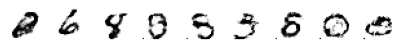

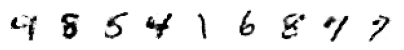

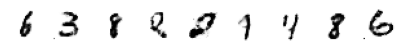

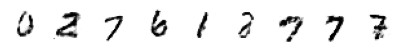

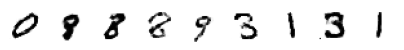

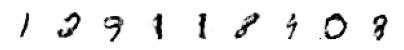

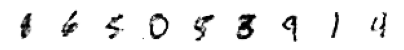

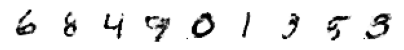

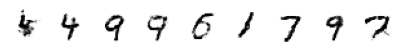

Epoch:160, Step:0, D-Loss:0.581, D-Acc:65.000, G-Loss:0.860
Epoch:160, Step:50, D-Loss:0.642, D-Acc:66.000, G-Loss:0.927
Epoch:160, Step:100, D-Loss:0.648, D-Acc:70.000, G-Loss:0.876
Epoch:160, Step:150, D-Loss:0.607, D-Acc:65.000, G-Loss:0.947
Epoch:160, Step:200, D-Loss:0.620, D-Acc:69.000, G-Loss:0.856
Epoch:160, Step:250, D-Loss:0.607, D-Acc:74.000, G-Loss:0.944
Epoch:160, Step:300, D-Loss:0.636, D-Acc:61.000, G-Loss:0.935
Epoch:160, Step:350, D-Loss:0.615, D-Acc:68.000, G-Loss:0.905
Epoch:160, Step:400, D-Loss:0.624, D-Acc:67.000, G-Loss:0.877
Epoch:160, Step:450, D-Loss:0.662, D-Acc:60.000, G-Loss:0.891
Epoch:161, Step:0, D-Loss:0.577, D-Acc:68.000, G-Loss:0.898
Epoch:161, Step:50, D-Loss:0.632, D-Acc:63.000, G-Loss:0.868
Epoch:161, Step:100, D-Loss:0.603, D-Acc:64.000, G-Loss:0.867
Epoch:161, Step:150, D-Loss:0.724, D-Acc:50.000, G-Loss:0.824
Epoch:161, Step:200, D-Loss:0.645, D-Acc:63.000, G-Loss:0.918
Epoch:161, Step:250, D-Loss:0.640, D-Acc:61.000, G-Loss:0.848
Epoch:161, Ste

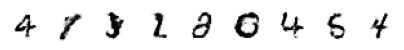

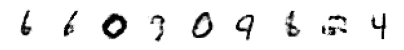

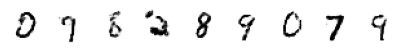

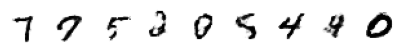

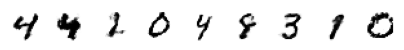

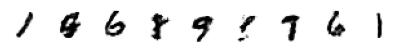

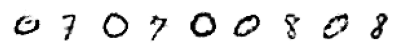

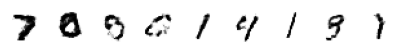

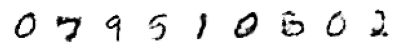

Epoch:170, Step:0, D-Loss:0.657, D-Acc:61.000, G-Loss:0.937
Epoch:170, Step:50, D-Loss:0.565, D-Acc:72.000, G-Loss:0.912
Epoch:170, Step:100, D-Loss:0.631, D-Acc:60.000, G-Loss:0.870
Epoch:170, Step:150, D-Loss:0.654, D-Acc:66.000, G-Loss:0.868
Epoch:170, Step:200, D-Loss:0.586, D-Acc:70.000, G-Loss:0.915
Epoch:170, Step:250, D-Loss:0.645, D-Acc:68.000, G-Loss:0.949
Epoch:170, Step:300, D-Loss:0.642, D-Acc:61.000, G-Loss:0.925
Epoch:170, Step:350, D-Loss:0.669, D-Acc:62.000, G-Loss:0.907
Epoch:170, Step:400, D-Loss:0.613, D-Acc:67.000, G-Loss:0.881
Epoch:170, Step:450, D-Loss:0.620, D-Acc:65.000, G-Loss:0.896
Epoch:171, Step:0, D-Loss:0.685, D-Acc:55.000, G-Loss:0.824
Epoch:171, Step:50, D-Loss:0.628, D-Acc:61.000, G-Loss:0.876
Epoch:171, Step:100, D-Loss:0.600, D-Acc:64.000, G-Loss:0.907
Epoch:171, Step:150, D-Loss:0.606, D-Acc:68.000, G-Loss:0.949
Epoch:171, Step:200, D-Loss:0.629, D-Acc:64.000, G-Loss:0.906
Epoch:171, Step:250, D-Loss:0.646, D-Acc:67.000, G-Loss:0.959
Epoch:171, Ste

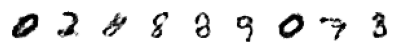

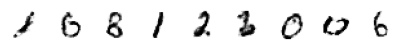

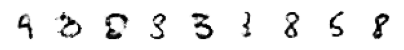

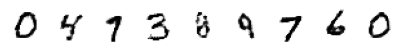

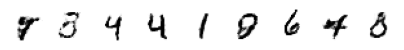

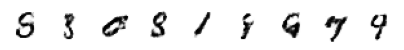

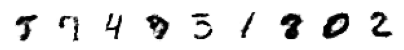

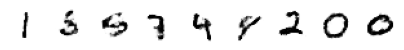

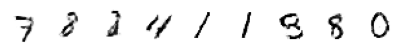

Epoch:180, Step:0, D-Loss:0.630, D-Acc:62.000, G-Loss:0.917
Epoch:180, Step:50, D-Loss:0.651, D-Acc:61.000, G-Loss:0.851
Epoch:180, Step:100, D-Loss:0.612, D-Acc:68.000, G-Loss:0.887
Epoch:180, Step:150, D-Loss:0.631, D-Acc:63.000, G-Loss:0.979
Epoch:180, Step:200, D-Loss:0.610, D-Acc:66.000, G-Loss:0.898
Epoch:180, Step:250, D-Loss:0.608, D-Acc:71.000, G-Loss:0.880
Epoch:180, Step:300, D-Loss:0.597, D-Acc:66.000, G-Loss:0.952
Epoch:180, Step:350, D-Loss:0.631, D-Acc:63.000, G-Loss:0.847
Epoch:180, Step:400, D-Loss:0.618, D-Acc:63.000, G-Loss:0.919
Epoch:180, Step:450, D-Loss:0.608, D-Acc:66.000, G-Loss:0.912
Epoch:181, Step:0, D-Loss:0.599, D-Acc:65.000, G-Loss:0.859
Epoch:181, Step:50, D-Loss:0.654, D-Acc:64.000, G-Loss:0.932
Epoch:181, Step:100, D-Loss:0.636, D-Acc:59.000, G-Loss:0.914
Epoch:181, Step:150, D-Loss:0.565, D-Acc:68.000, G-Loss:0.928
Epoch:181, Step:200, D-Loss:0.572, D-Acc:76.000, G-Loss:0.884
Epoch:181, Step:250, D-Loss:0.636, D-Acc:64.000, G-Loss:0.954
Epoch:181, Ste

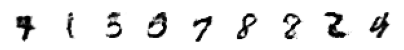

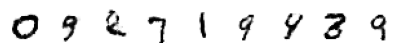

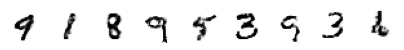

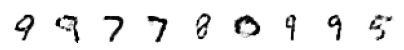

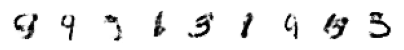

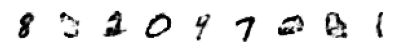

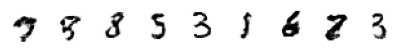

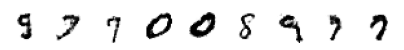

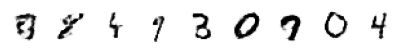

Epoch:190, Step:0, D-Loss:0.711, D-Acc:55.000, G-Loss:0.896
Epoch:190, Step:50, D-Loss:0.616, D-Acc:60.000, G-Loss:1.020
Epoch:190, Step:100, D-Loss:0.638, D-Acc:63.000, G-Loss:0.868
Epoch:190, Step:150, D-Loss:0.606, D-Acc:70.000, G-Loss:0.906
Epoch:190, Step:200, D-Loss:0.612, D-Acc:68.000, G-Loss:0.879
Epoch:190, Step:250, D-Loss:0.697, D-Acc:58.000, G-Loss:0.822
Epoch:190, Step:300, D-Loss:0.702, D-Acc:55.000, G-Loss:0.922
Epoch:190, Step:350, D-Loss:0.559, D-Acc:75.000, G-Loss:0.853
Epoch:190, Step:400, D-Loss:0.597, D-Acc:63.000, G-Loss:0.895
Epoch:190, Step:450, D-Loss:0.647, D-Acc:64.000, G-Loss:0.942
Epoch:191, Step:0, D-Loss:0.615, D-Acc:61.000, G-Loss:0.929
Epoch:191, Step:50, D-Loss:0.626, D-Acc:64.000, G-Loss:0.918
Epoch:191, Step:100, D-Loss:0.597, D-Acc:73.000, G-Loss:0.943
Epoch:191, Step:150, D-Loss:0.651, D-Acc:58.000, G-Loss:0.918
Epoch:191, Step:200, D-Loss:0.657, D-Acc:59.000, G-Loss:0.947
Epoch:191, Step:250, D-Loss:0.587, D-Acc:69.000, G-Loss:0.944
Epoch:191, Ste

In [ ]:
epochs = 200
batch_size = 100
steps = 500
noise_size = 50

losses_d = []
losses_g = []

# 할당한 epoch(stage) 에서
for i in range(0, epochs):
    # 10 epoch 마다 결과 display
    if (i%10 == 0):
        show_generator_results(generator_network)
    for j in range(steps):
        # 가짜 이미지(0) 와 진짜 이미지(1)
        fake_samples = get_fake_samples(generator_network, batch_size//2, noise_size)
        real_samples = get_real_samples(batch_size=batch_size//2)

        fake_y = np.zeros((batch_size//2, 1))
        real_y = np.ones((batch_size//2, 1))
        
        input_batch = np.vstack((fake_samples, real_samples))
        output_labels = np.vstack((fake_y, real_y))
        
        # 임시적으로 Discriminator를 학습 가능하게 해서 loss 값 변경
        discriminator_network.trainable=True
        loss_d = discriminator_network.train_on_batch(input_batch, output_labels)
        
        gan_input = get_random_noise(batch_size, noise_size)
        
        # Discriminator 가 이 샘플들을 실제 이미지라고 믿게하고 generator 학습을 위해 loss 값 계산
        gan_output = np.ones((batch_size))
        
        # Discriminator 를 학습 불가능하게 만들고 GAN 모델 학습
        discriminator_network.trainable=False
        loss_g = gan_model.train_on_batch(gan_input, gan_output)

        losses_d.append(loss_d[0])
        losses_g.append(loss_g)
        
        # 50 step 마다 loss 값 display
        if j%50 == 0:
            print ("Epoch:%.0f, Step:%.0f, D-Loss:%.3f, D-Acc:%.3f, G-Loss:%.3f"%(i,j,loss_d[0],loss_d[1]*100,loss_g))

# Show Results

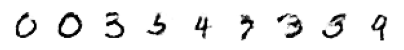

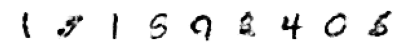

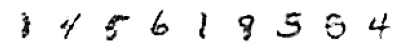

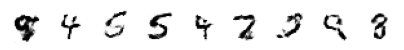

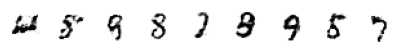

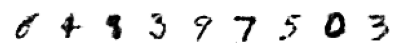

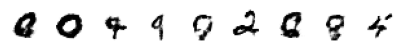

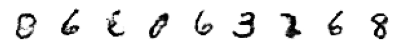

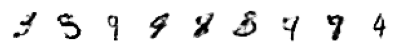

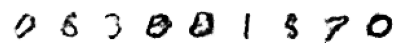

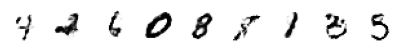

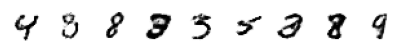

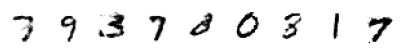

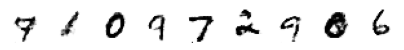

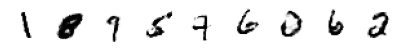

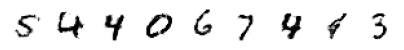

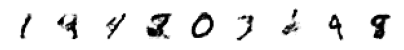

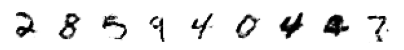

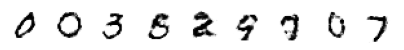

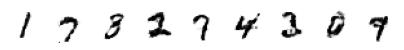

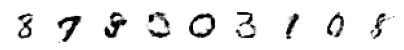

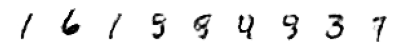

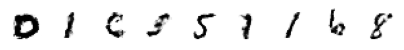

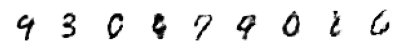

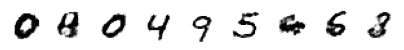

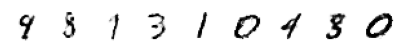

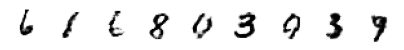

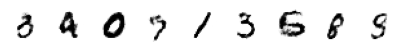

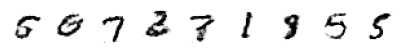

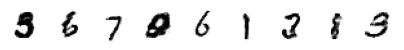

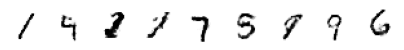

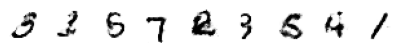

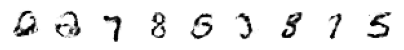

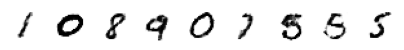

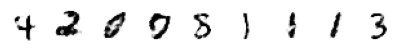

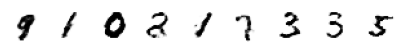

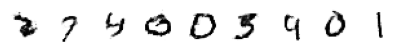

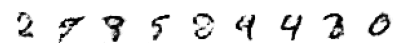

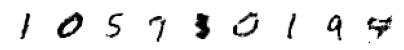

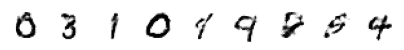

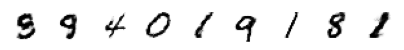

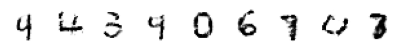

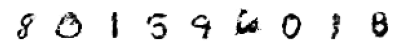

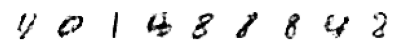

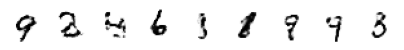

In [ ]:
#Generating Unlimited samples
for i in range(5):
    show_generator_results(generator_network)

# Plot GAN loss

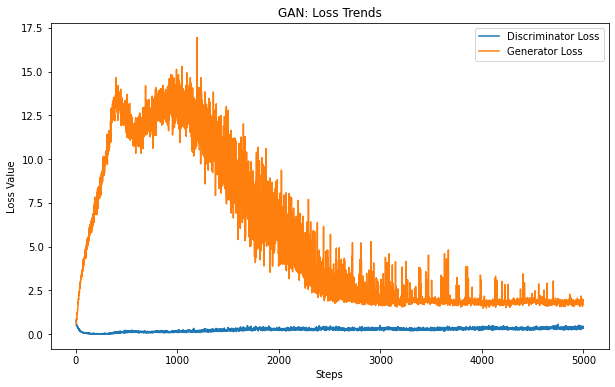

In [ ]:
steps = [i for i in range(len(losses_d))]
plt.figure(figsize=(10, 6))
plt.plot(losses_d[:5000])
plt.plot(losses_g[:5000])
plt.xlabel('Steps')
plt.ylabel('Loss Value')
plt.title("GAN: Loss Trends")
plt.legend(['Discriminator Loss', 'Generator Loss'])
plt.show()